In [1]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21

ComputeMyTaskNumber('Salikhova_Kariya')

16

## Задача: Реализация алгоритма iGBRT с квадратичной фунцией потерь.
http://proceedings.mlr.press/v14/mohan11a/mohan11a.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Подготовка данных

In [3]:
max_idx = 0
with open("reg.train.txt") as f:
    for line in f:
        items = line.split()
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            if int(idx) > max_idx:
                max_idx = int(idx)
        
with open("reg.test.txt") as f:
    for line in f:
        items = line.split()
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            if int(idx) > max_idx:
                max_idx = int(idx)
max_idx

245

In [21]:
y_train = []
X_train = []
with open("reg.train.txt") as f:
    for line in f:
        features = np.array((max_idx+1) * [100], dtype=float)
        items = line.split()
        y_train.append(float(items[0]))
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            features[int(idx)] = float(value)
        X_train.append(features)
        
y_test = []
X_test = []
with open("reg.test.txt") as f:
    for line in f:
        features = np.array((max_idx+1) * [10], dtype=float)
        items = line.split()
        y_test.append(float(items[0]))
        items = items[1:]
        for item in items:
            idx, value = item.split(':')
            features[int(idx)] = float(value)
        X_test.append(features)        

In [22]:
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

### Реализация

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from time import time

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [24]:
class My_DecisionTree:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.tree = dict()
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }      

    def sort_samples(self, x, y):
        sorted_idx = x.argsort(axis=0)
        return np.sort(x, axis=0), y[sorted_idx]
    
    def div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def fit_node(self, x, y, node_id, depth):
        if (depth == self.max_depth) or (x.shape[0] < self.min_samples_split):
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
            return
        
        sorted_x, sorted_y = self.sort_samples(x, y)
        lengths = np.array(range(np.cumsum(sorted_y, axis=0).shape[0] + 1)[1:]).reshape(-1, 1)
        loss1 = np.cumsum(sorted_y ** 2, axis=0) - (np.cumsum(sorted_y, axis=0) ** 2 / lengths)
        lengths = lengths[::-1]
        loss2 = np.cumsum(sorted_y[::-1] ** 2, axis=0)[::-1] - (np.cumsum(sorted_y[::-1], axis=0)[::-1] ** 2 / lengths)
        loss1[:-1] += loss2[1:]
        loss = loss1
        
        shifted_x = np.roll(sorted_x, axis=0, shift=-1)
        loss[np.isclose(sorted_x, shifted_x, atol=1e-3)] = np.nan 
        try:
            argmin = np.nanargmin(loss) #if loss - list of nans(all features are unimportant), raise ValueError
        except ValueError:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
            return
        
        best_sample_idx = argmin // loss.shape[1]
        best_feature_idx = argmin - best_sample_idx*loss.shape[1]
        threshold = sorted_x[best_sample_idx, best_feature_idx]
        x_l, x_r, y_l, y_r = self.div_samples(x, y, best_feature_idx, threshold)
        
        if x_l.shape[0] < self.min_samples_leaf or x_l.shape[0] < self.min_samples_leaf:
            self.tree[node_id] = (self.LEAF_TYPE, np.mean(y))
        else:
            self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_idx, threshold)
            self.fit_node(x_l, y_l, 2*node_id + 1, depth + 1)
            self.fit_node(x_r, y_r, 2*node_id + 2, depth + 1)

    def fit(self, x, y):
        self.features = np.arange(x.shape[1])
        self.fit_node(x[:, self.features], y, 0, 0)
        return self

    def predict_node(self, x, node_id):
        node = self.tree[node_id]
        res = np.zeros(x.shape[0])
        if node[0] == self.__class__.NON_LEAF_TYPE:
            node_type, best_feature_idx, threshold = node
            idx = np.where(x[:, best_feature_idx] <= threshold)
            res[idx] = self.predict_node(x[idx], 2*node_id + 1)
            idx = np.where(x[:, best_feature_idx] > threshold)
            res[idx] = self.predict_node(x[idx], 2*node_id + 2)
            return res
        return np.array([node[1]]*x.shape[0])
            
    def predict(self, X):
        x = X[:, self.features]
        res = self.predict_node(X, 0)
        return res

In [25]:
my_clf = My_DecisionTree(max_depth=10)
clf = DecisionTreeRegressor(max_depth=10)

In [26]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
my_pred = my_clf.predict(X_test)
pred = clf.predict(X_test)
print("My DecisionTree: MSE = {}".format(mean_squared_error(y_test, my_pred)))
print("Sklearn DecisionTreeRegressor: MSE = {}".format(mean_squared_error(y_test, pred)))

My DecisionTree: MSE = 0.9550815177642769
Sklearn DecisionTreeRegressor: MSE = 1.5671698498178244


In [27]:
class My_RandomForest:
    def __init__(self, n_estimators=20, max_depth=None, min_samples_split=2, min_samples_leaf = 1):
        self.n_estimators = int(n_estimators)
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = min_samples_leaf
        self.models = []
        
    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }  
            
    def fit(self, X, y):
        for i in range(self.n_estimators):
            tree = My_DecisionTree(min_samples_split=self.min_samples_split,
                                      max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            idx = np.random.randint(0, X.shape[0], X.shape[0]) # 1 x X.shape[0]
            tree.fit(X[idx], y[idx])
            self.models.append(tree)
        return self

    def predict(self, X):
        res = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            res += self.models[i].predict(X)
        return res/self.n_estimators

In [28]:
my_clf = My_RandomForest(max_depth=10)
clf = RandomForestRegressor(max_depth=10)

In [29]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
my_pred = my_clf.predict(X_test)
pred = clf.predict(X_test)
print("My RandomForest: MSE = {}".format(mean_squared_error(y_test, my_pred)))
print("Sklearn RandomForestRegressor: MSE = {}".format(mean_squared_error(y_test, pred)))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


My RandomForest: MSE = 0.7805622933038515
Sklearn RandomForestRegressor: MSE = 0.9044175374616276


In [30]:
class iGBRT:
    def __init__(self, learning_rate=0.1, n_estimators=20, n_estimators_for_rf=20,
                 min_samples_split=2, max_depth=3, max_features=None):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.n_estimators_for_rf = n_estimators_for_rf
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.models = []
        self.k = []
        
    def get_params(self, deep=True):
        return {
            "learning_rate": self.learning_rate,
            "n_estimators": self.n_estimators,
            "n_estimators_for_rf": n_estimators_for_rf,
            "min_samples_split": self.min_samples_split,
            "max_depth": self.max_depth,
            "max_features": self.max_features
        }
    
    def best_ro(self, ro_type, y, pred, y_pred=None):
        if ro_type == 0:
            ro_list = np.arange(0, 3, 0.001)
            min_L = 1000
            best_ro = 0
            for i in range(len(ro_list)):
                ro = ro_list[i]
                L = np.mean((y - ro*pred)**2)
                if L < min_L:
                    min_L = L
                    best_ro = ro
        else:
            ro_list = np.arange(-3, 3, 0.001)
            min_L = 1000
            best_ro = -3
            for i in range(len(ro_list)):
                ro = ro_list[i]
                L = np.mean((y - (y_pred+ro*pred))**2)
                if L < min_L:
                    min_L = L
                    best_ro = ro
        return best_ro
    
    def fit(self, X, y):
        model_0 = My_RandomForest(n_estimators=self.n_estimators_for_rf, max_depth=self.max_depth,
                                               min_samples_split=self.min_samples_split)
        model_0.fit(X, y)
        pred_0 = model_0.predict(X)
        ro_0 = self.best_ro(0, y, pred_0)
        y_pred = ro_0*pred_0
        self.models.append(model_0)
        self.k.append(ro_0)
        for t in range(self.n_estimators)[1:]:
            r = y - y_pred #L = (y-f)^2, dL = 2*(y-f)
            model_t = My_DecisionTree(max_depth=self.max_depth,
                                      min_samples_split=self.min_samples_split)
            model_t.fit(X, r)
            pred_t = model_t.predict(X)
            ro_t = self.best_ro(1, y, pred_t, y_pred)
            y_pred += self.learning_rate * ro_t*pred_t
            self.models.append(model_t)
            self.k.append(self.learning_rate * ro_t)
    
    def predict(self, X):
        res = np.zeros(len(X))
        res_list = []
        for i, model in enumerate(self.models):
            model_res = self.k[i] * model.predict(X)
            res += model_res
        return res
    
    def staged_predict(self, X):
        res = np.zeros(len(X))
        for i, model in enumerate(self.models):
            res += self.k[i] * model.predict(X)
            yield res

### Результаты

In [31]:
T = 100
my_clf = iGBRT(n_estimators=T)
clf = GradientBoostingRegressor(n_estimators=T, criterion='mse')

In [32]:
%time my_clf.fit(X_train, y_train)

Wall time: 2min 7s


In [33]:
%time clf.fit(X_train, y_train)

Wall time: 15.9 s


GradientBoostingRegressor(criterion='mse')

In [34]:
my_pred_train = my_clf.predict(X_train)
pred_train = clf.predict(X_train)
print('Train iGBRT: MSE = {}'.format(mean_squared_error(y_train, my_pred_train)))
print('Train Sklearn GBR: MSE = {}'.format(mean_squared_error(y_train, pred_train)))
my_train_loss = []
train_loss = []
for my_res in my_clf.staged_predict(X_train):
    my_train_loss.append(mean_squared_error(y_train, my_res))
for res in clf.staged_predict(X_train):
    train_loss.append(mean_squared_error(y_train, res))

Train iGBRT: MSE = 0.4635013188335844
Train Sklearn GBR: MSE = 0.4605115975890065


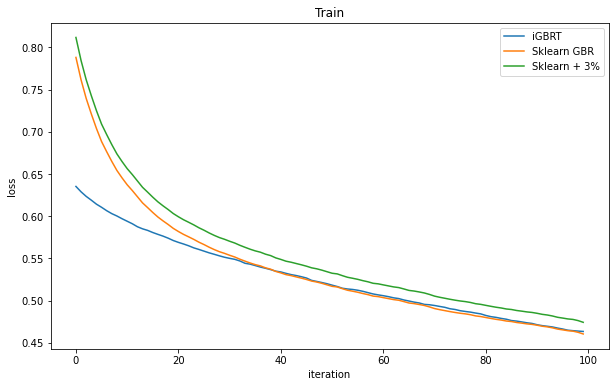

In [35]:
plt.figure(figsize=(10, 6))
plt.title('Train')
plt.plot(range(T), my_train_loss, label='iGBRT')
plt.plot(range(T), train_loss, label='Sklearn GBR')
plt.plot(range(T), np.array([1.03]*len(train_loss))*train_loss, label='Sklearn + 3%')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [36]:
my_pred_test = my_clf.predict(X_test)
pred_test = clf.predict(X_test)
print('Test iGBRT: MSE = {}'.format(mean_squared_error(y_test, my_pred_test)))
print('Test Sklearn GBR: MSE = {}'.format(mean_squared_error(y_test, pred_test)))
my_test_loss = []
test_loss = []
for my_res in my_clf.staged_predict(X_test):
    my_test_loss.append(mean_squared_error(y_test, my_res))
for res in clf.staged_predict(X_test):
    test_loss.append(mean_squared_error(y_test, res))

Test iGBRT: MSE = 0.784334601118655
Test Sklearn GBR: MSE = 0.9863779628199


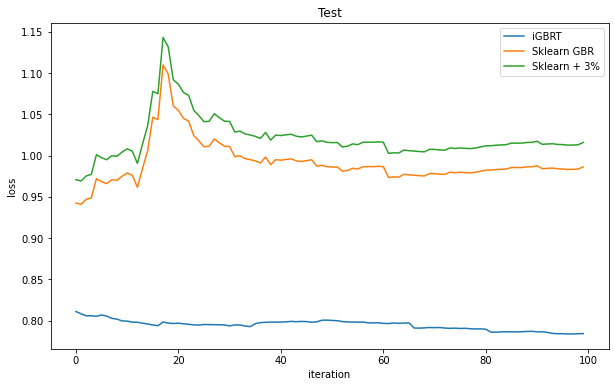

In [37]:
plt.figure(figsize=(10, 6))
plt.title('Test')
plt.plot(range(T), my_test_loss, label='iGBRT')
plt.plot(range(T), test_loss, label='Sklearn GBR')
plt.plot(range(T), np.array([1.03]*len(test_loss))*test_loss, label='Sklearn + 3%')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

#### Наблюдение:
Заметила, что результаты сильно зависят от данных (если рассматривать только данный датасет, то результаты зависят от числа, которым заполняю пропуски в фичах). Наверное, это характеризует эту реализацию модели с плохой стороны, как не универсальную. С другой стороны, модель Sklearn тоже на некоторых данных ведет себя довольно странно.